# SLCP with AMNPE

In [1]:
import numpy as np
import torch
import torch.nn as nn

from datetime import datetime

from lampe.simulators.slcp import SLCP
from lampe.nn import AMNPE, NLLLoss
from lampe.masks import UniformMask
from lampe.optim import AdamW, ReduceLROnPlateau
from lampe.train import SummaryWriter, Trainer, AMNPEPipe
from lampe.mcmc import LRESampler
from lampe.plot import corner

In [2]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(log_dir=f'runs/slcp/{now}')

## Training

In [3]:
sim = SLCP().cuda()
train_loader = sim.iterable(batch_size=1024, length=256)
valid_loader = sim.iterable(batch_size=1024, length=32)

In [4]:
model = AMNPE(5, 8, prior=sim.prior, embedding=nn.Flatten(-2), architecture='affine', num_transforms=7, num_blocks=5, hidden_features=256)
model.train()
model.cuda()

AMNPE(
  (flow): MAF(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=5, out_features=256, bias=True)
            (context_layer): Linear(in_features=13, out_features=256, bias=True)
            (blocks): ModuleList(
              (0): MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=256, out_features=256, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (1): MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=256, out_features=256, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (2): MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=256, out_features=256, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (

In [5]:
pipe = AMNPEPipe(model, mask_sampler=UniformMask(5).cuda(), criterion=NLLLoss())
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, gamma=0.5, patience=7)
trainer = Trainer(pipe, train_loader, valid_loader, optimizer, scheduler, clip=1., writer=writer)

for epoch in trainer(128):
    pass  # something to do in between epochs

Epochs: 100%|██████████████████████████████████████████████| 128/128 [18:51<00:00,  8.84s/epoch, loss=-2.68, lr=0.0005]


## Evaluation

In [6]:
_ = model.eval()

### Parameters

In [7]:
parameters = sum(p.numel() for p in model.parameters())
parameters

2356550

### Speed

In [8]:
theta, x = next(iter(train_loader))
batches = 2 ** 10

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

with torch.no_grad():
    for _ in range(batches):
        y = model.embedding(x)
        _ = model(theta, y)

end.record()

torch.cuda.synchronize()

seconds = start.elapsed_time(end) * 1e-3

speed = batches / seconds
speed

168.14482273352075

### Corner plot

In [9]:
theta = torch.tensor([0.3517, -0.0883, -1.4778, 1.6406, -1.9085]).cuda()
x = sim(theta)
y = model.embedding(x)

In [10]:
sigma = 0.05 * (sim.upper - sim.lower)

sampler = LRESampler(sim.log_prob, sim.prior, x, batch_size=2 ** 12, sigma=sigma)
thetas = torch.cat([t.cpu() for t in sampler(2 ** 13, burn=2 ** 12, skip=2 ** 4)])

In [11]:
hists = np.ndarray((5, 5), dtype=object)

for i in range(5):
    for j in range(i + 1):
        mask = torch.tensor([k in [i, j] for k in range(5)])
        
        sampler = LRESampler(model[mask], sim.marginal_prior(mask), y, batch_size=2 ** 12)
        hists[i, j] = sampler.grid(100, sim.lower[mask], sim.upper[mask]).cpu().numpy().T

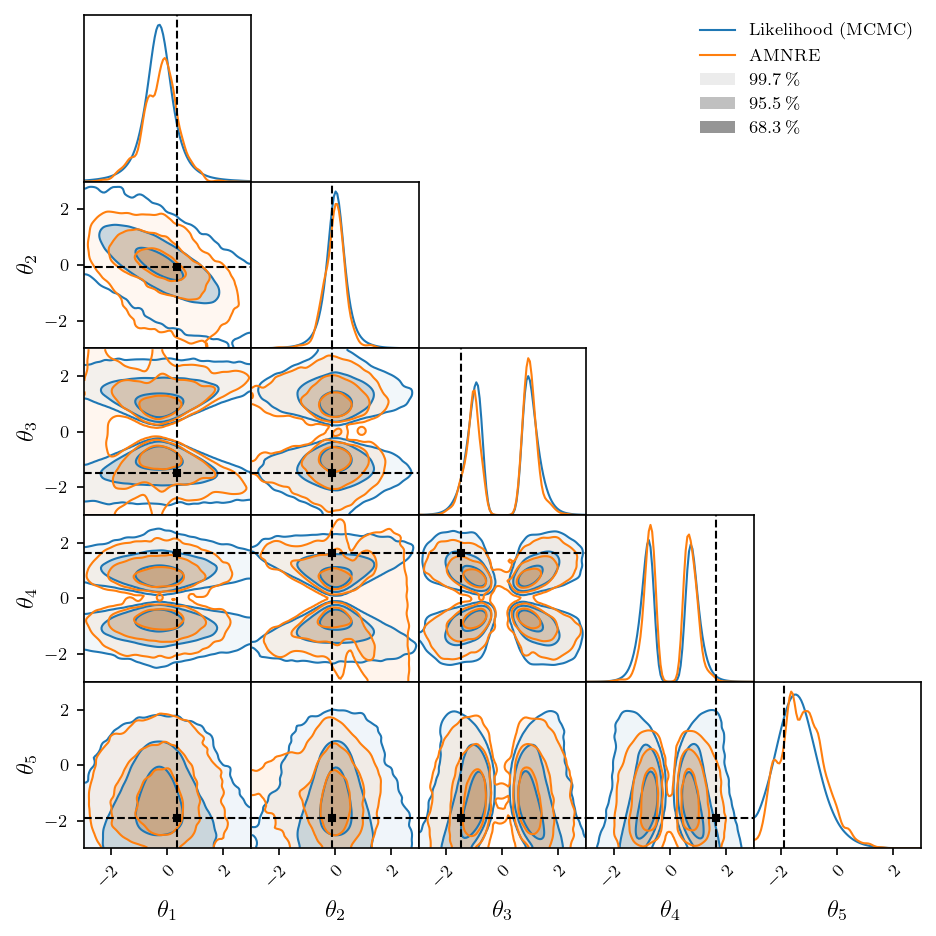

In [12]:
bounds = (sim.lower.cpu().numpy(), sim.upper.cpu().numpy())

fig = corner(
    thetas.numpy(),
    smooth=2.,
    bounds=bounds,
    labels=sim.labels,
    legend='Likelihood (MCMC)',
    markers=[theta.cpu().numpy()],
)

fig = corner(
    hists,
    smooth=2.,
    bounds=bounds,
    legend='AMNRE',
    figure=fig,
)

## Save

In [13]:
writer.add_hparams(
    hparam_dict={
        'simulator': 'SLCP',
        'embedding': 'Flatten',
        'model': 'AMNPE',
        'architecture': 'affine',
        'transforms': 7,
        'layers_per_transform': 3,
        'neurons_per_layer': 128,
        'epochs': 64,
        'optimizer': 'AdamW',
        'learning_rate': 1e-3,
        'weight_decay': 1e-3,
        'scheduler': 'ReduceLROnPlateau',
        'gamma': 0.5,
        'patience': 7,
        'gradient_clip': 1.,
    },
    metric_dict={
        'parameters': parameters,
        'batches_per_second': speed,
    },
)